# **1. Instalación tensor y keras**

In [ ]:
# Esta línea instala el paquete TensorFlow en el entorno actual de Python
!pip install tensorflow

In [ ]:
# Esta línea instala la biblioteca Keras, una API de alto nivel para construir y entrenar modelos de redes neuronales
!pip install keras

# **2. Importar librerías necesarias**

In [ ]:
# Carga el framework TensorFlow
import tensorflow as tf

# Permite trabajar con archivos ZIP
import zipfile

# Importa capas y modelos desde Keras
from tensorflow.keras import layers, models

# Herramientas para aumentar datos de imagen
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Detiene el entrenamiento si no mejora
from tensorflow.keras.callbacks import EarlyStopping

# Librería para gráficos
import matplotlib.pyplot as plt

# Operaciones numéricas con arrays
import numpy as np

# Interacción con el sistema de archivos
import os

# **3. Descomprimir el archivo ZIP**

In [ ]:
# Ruta al archivo ZIP
zip_path = "/content/GenderDataset.zip"

# Ruta donde se descomprimirá
extract_path = "/content/GenderDataset"

# Descomprimir
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verificar contenido de la carpeta descomprimida
print("Carpetas dentro de GenderDataset:", os.listdir(extract_path))

Carpetas dentro de GenderDataset: ['Validation', 'Training']


# **4. Verificar rutas**

In [ ]:
# Define la ruta base del conjunto de datos, que corresponde a la carpeta
# donde se descomprimieron las imágenes
base_dir = "/content/GenderDataset"

# Construye la ruta completa a la carpeta de entrenamiento,
# donde se encuentran las imágenes que se usarán para entrenar el modelo
train_dir = os.path.join(base_dir, "Training")

# Construye la ruta completa a la carpeta de validación,
# que contiene las imágenes que se usarán para evaluar el desempeño del modelo
validation_dir = os.path.join(base_dir, "Validation")

# Imprime la ruta completa de la carpeta de entrenamiento
print("Train dir:", train_dir)

# Imprime la ruta completa de la carpeta de validación
print("Validation dir:", validation_dir)

Train dir: /content/GenderDataset/Training
Validation dir: /content/GenderDataset/Validation


# **5. Aumento de datos**

In [ ]:
# Importa la clase ImageDataGenerator, que permite aplicar transformaciones a las imágenes
# y generar lotes de datos de forma automática para el entrenamiento y validación
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crea un generador de datos para el conjunto de entrenamiento.
# Las imágenes se reescalan a valores entre 0 y 1, se aplican rotaciones aleatorias,
# zoom aleatorio, y se permite voltear horizontalmente las imágenes para aumentar la variedad del set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Crea un generador de datos para el conjunto de validación.
# Solo se reescalan las imágenes, sin aplicar aumentos, ya que en validación se evalúa con datos reales sin alterar
val_datagen = ImageDataGenerator(rescale=1./255)

# **6. Crear generadores**

Los generadores como train_generator y val_generator cargan y procesan imágenes por lotes directamente desde carpetas, permitiendo manejar grandes datos sin usar mucha memoria. Además, aplican preprocesamiento y, en entrenamiento, aumentan la variedad de datos para mejorar la calidad del modelo.

In [ ]:
# Crea el generador de imágenes para el conjunto de entrenamiento a partir de la carpeta correspondiente.
# Las imágenes se redimensionan a 150x150 píxeles, se agrupan en lotes de 32,
# y se utiliza clasificación binaria ya que solo hay dos clases: female y male.
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Crea el generador de imágenes para el conjunto de validación.
# Aplica las mismas dimensiones de imagen y tamaño de lote, y también usa clasificación binaria.
val_generator = val_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


# **7. Construir la arquitectura de la CNN**

Este modelo CNN tiene tres bloques de convolución y max pooling que extraen y simplifican características visuales de las imágenes. Después, aplana los datos y usa una capa densa con dropout para evitar sobreajuste. Finalmente, la capa de salida con activación sigmoide produce la probabilidad para clasificar la imagen como female o male.

In [ ]:
# Define un modelo secuencial de redes neuronales convolucionales (CNN)
model = models.Sequential([

    # Primera capa convolucional con 32 filtros de tamaño 3x3 y función de activación ReLU
    # Se especifica la forma de entrada: imágenes RGB de 150x150 píxeles
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),

    # Capa de max pooling para reducir la dimensionalidad, usando una ventana 2x2
    layers.MaxPooling2D(2, 2),

    # Segunda capa convolucional con 64 filtros y activación ReLU
    layers.Conv2D(64, (3, 3), activation='relu'),

    # Segunda capa de max pooling para seguir reduciendo dimensiones
    layers.MaxPooling2D(2, 2),

    # Tercera capa convolucional con 128 filtros y activación ReLU
    layers.Conv2D(128, (3, 3), activation='relu'),

    # Tercera capa de max pooling para reducción adicional de dimensionalidad
    layers.MaxPooling2D(2, 2),

    # Aplana la salida 3D en un vector 1D para conectar con capas densas
    layers.Flatten(),

    # Capa Dropout que apaga aleatoriamente el 50% de neuronas durante el entrenamiento
    # Esto ayuda a evitar el sobreajuste
    layers.Dropout(0.5),

    # Capa densa totalmente conectada con 512 neuronas y activación ReLU
    layers.Dense(512, activation='relu'),

    # Capa de salida con una neurona y activación sigmoide para clasificación binaria (female o male)
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **8. Compilar el modelo**

In [ ]:
# Configura el optimizador Adam, que ajusta los pesos durante el entrenamiento
# Usa la función de pérdida 'binary_crossentropy' indicada para problemas de clasificación binaria
# Evalúa el rendimiento del modelo con la métrica de exactitud (accuracy)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# **9. Mostrar la arquitectura del modelo**

In [ ]:
# Muestra un resumen detallado de la arquitectura del modelo,
# incluyendo las capas, su forma de salida y la cantidad de parámetros entrenables
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

# **10.  Agregar EarlyStopping**

EarlyStopping es una técnica que detiene el entrenamiento de un modelo automáticamente cuando la métrica de validación deja de mejorar, evitando así el sobreajuste y ahorrando tiempo. Se monitorea, por ejemplo, la pérdida o precisión en validación, y si no mejora después de cierto número de épocas, el entrenamiento se para.


In [ ]:
# Crea un callback para detener el entrenamiento si la pérdida en validación
# no mejora durante 3 épocas consecutivas, y restaura los mejores pesos obtenidos
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# **11. Entrenar el modelo**

In [ ]:
# Inicia el proceso de entrenamiento del modelo utilizando los datos generados por train_generator
# El entrenamiento se realizará por un máximo de 15 épocas (iteraciones completas sobre los datos)
# Se evalúa el desempeño del modelo en cada época usando los datos de validación provistos por val_generator
# Se incluye el callback early_stop para detener el entrenamiento de forma anticipada
# si la pérdida en el conjunto de validación no mejora durante 3 épocas consecutivas
# Además, early_stop restaurará los pesos del modelo correspondientes a la mejor época registrada
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 277s 184ms/step - accuracy: 0.7383 - loss: 0.5044 - val_accuracy: 0.9240 - val_loss: 0.1953
Epoch 2/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 260s 177ms/step - accuracy: 0.8978 - loss: 0.2569 - val_accuracy: 0.9390 - val_loss: 0.1641
Epoch 3/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 263s 179ms/step - accuracy: 0.9171 - loss: 0.2133 - val_accuracy: 0.9448 - val_loss: 0.1455
Epoch 4/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 261s 177ms/step - accuracy: 0.9303 - loss: 0.1879 - val_accuracy: 0.9576 - val_loss: 0.1142
Epoch 5/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 261s 178ms/step - accuracy: 0.9348 - loss: 0.1750 - val_accuracy: 0.9566 - val_loss: 0.1125
Epoch 6/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 263s 179ms/step - accuracy: 0.9424 - loss: 0.1592 - val_accuracy: 0.9599 - val_loss: 0.1201
Epoch 7/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 266s 181ms/step - accuracy: 0.9442 - loss: 0.1513 - val_accuracy: 0.9608 - val_loss: 0.1069
Epoch 8/10
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 265s 181ms/step - ac

# **12. Graficar precisión y pérdida**

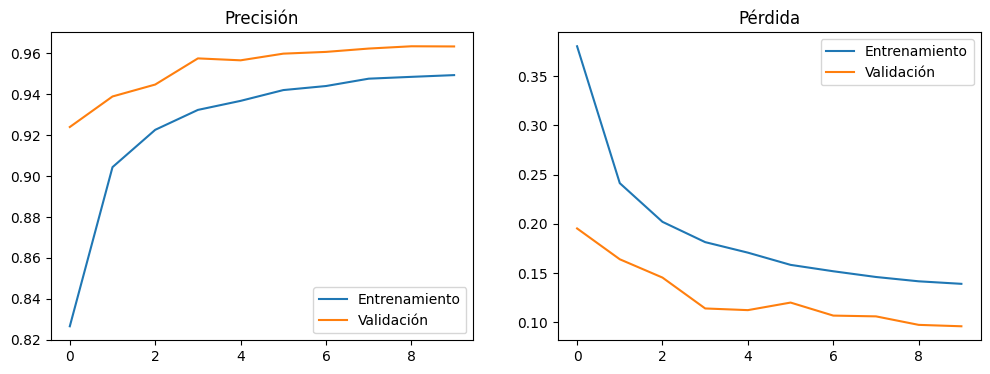

In [ ]:
# Crea una figura para mostrar dos gráficos lado a lado con tamaño personalizado
plt.figure(figsize=(12, 4))

# Primer gráfico: precisión durante el entrenamiento y la validación a lo largo de las épocas
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.legend()

# Segundo gráfico: evolución de la función de pérdida durante el entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()

# Muestra los gráficos generados
plt.show()

# **13. Evaluar el modelo con el conjunto**

In [ ]:
# Evalúa el modelo usando el conjunto de validación para obtener la pérdida y precisión finales
val_loss, val_accuracy = model.evaluate(val_generator)

# Muestra la precisión final del modelo en el conjunto de validación con cuatro decimales
print(f'\nPrecisión en validación: {val_accuracy:.4f}')

365/365 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9650 - loss: 0.0926

Precisión en validación: 0.9634


# **14. Hacer predicciones con nuevas imágenes**

In [ ]:
# Obtiene el siguiente lote de imágenes y etiquetas desde el generador de validación
sample_images, sample_labels = next(val_generator)

# Usa el modelo para predecir las clases de las imágenes del lote obtenido
predictions = model.predict(sample_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


# **15. Visualizar algunas predicciones**

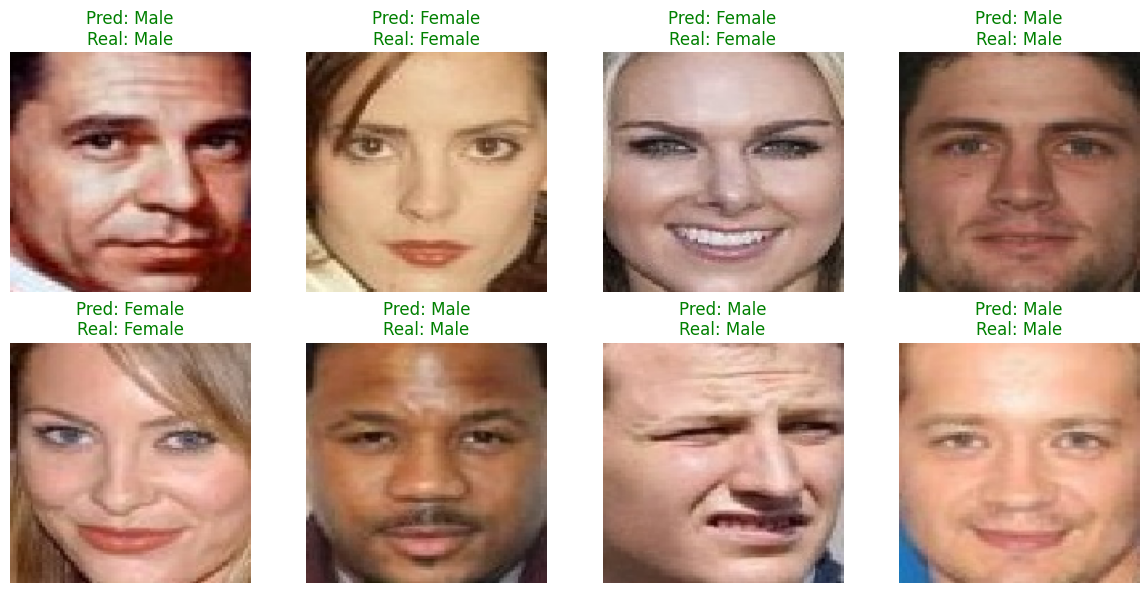

In [ ]:
# Define los nombres de las clases para facilitar la interpretación de las etiquetas
class_names = ['Female', 'Male']

# Crea una figura amplia para mostrar múltiples imágenes con sus predicciones
plt.figure(figsize=(12, 6))

# Itera sobre las primeras 8 imágenes del lote para visualizarlas junto a sus etiquetas
for i in range(8):
    # Crea una subgráfica para cada imagen en una grilla de 2 filas por 4 columnas
    plt.subplot(2, 4, i + 1)

    # Muestra la imagen i-ésima del lote actual
    plt.imshow(sample_images[i])

    # Determina la predicción del modelo: si la probabilidad es mayor a 0.5, es 'Female', si no, 'Male'
    pred = 'Male' if predictions[i] > 0.5 else 'Female'

    # Obtiene la etiqueta real de la imagen usando las clases definidas
    true = class_names[int(sample_labels[i])]

    # Define el color del título: verde si la predicción es correcta, rojo si es incorrecta
    color = 'green' if pred == true else 'red'

    # Muestra el título con la predicción y la etiqueta real en el color correspondiente
    plt.title(f'Pred: {pred}\nReal: {true}', color=color)

    # Oculta los ejes para mejorar la visualización
    plt.axis('off')

# Ajusta el diseño para evitar que los elementos se sobrepongan
plt.tight_layout()

# Muestra la figura con todas las imágenes y sus títulos
plt.show()

# **16. Guardar y cargar el modelo entrenado**

In [ ]:
# Guarda el modelo entrenado en un archivo con formato HDF5 (.h5)
model.save('modelo_Female_Male.h5')

# Carga el modelo previamente guardado desde el archivo para usarlo o evaluarlo
modelo_cargado = tf.keras.models.load_model('modelo_Female_Male.h5')

##Guardar en Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Guardar el modelo en Drive
model.save('/content/drive/MyDrive/modelo_Female_Male.h5')

Mounted at /content/drive


##¿Cómo cargarlo en una nueva sesión?

In [ ]:
import tensorflow as tf

# Montar Drive
from google.colab import drive
drive.mount('/content/drive')

# Cargar el modelo desde Drive
modelo_cargado = tf.keras.models.load_model('/content/drive/MyDrive/modelo_Female_Male.h5')

# Ver resumen
modelo_cargado.summary()

Mounted at /content/drive


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,179 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# **17. Probando el modelo**

Saving 078387.jpg.jpg to 078387.jpg (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


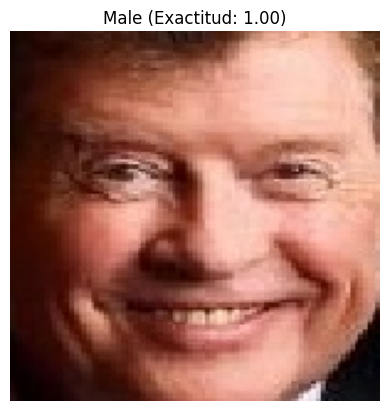

In [ ]:
# Importa el módulo para subir archivos en Google Colab
from google.colab import files

# Abre un diálogo para que el usuario suba imágenes desde su dispositivo
uploaded = files.upload()

# Importa funciones para procesar imágenes y manejo de arreglos
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Función que carga imágenes subidas, las prepara y hace predicciones con el modelo
def cargar_y_predecir(imagenes, modelo):
    for nombre_archivo in imagenes:
        # Carga la imagen y la redimensiona a 150x150 píxeles
        img = image.load_img(nombre_archivo, target_size=(150, 150))

        # Convierte la imagen en un array NumPy y normaliza los valores a [0,1]
        img_array = image.img_to_array(img) / 255.0

        # Añade una dimensión extra para simular un batch de tamaño 1
        img_array = np.expand_dims(img_array, axis=0)

        # Realiza la predicción con el modelo cargado y obtiene el valor de probabilidad
        prediccion = modelo.predict(img_array)[0][0]

        # Determina la clase según el umbral 0.5 y calcula la confianza
        clase = "Male" if prediccion > 0.5 else "Female"

        confianza = prediccion if prediccion > 0.5 else 1 - prediccion

        # Muestra la imagen con su predicción y nivel de confianza en el título
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{clase} (Exactitud: {confianza:.2f})")
        plt.show()

# Llama a la función pasando los archivos subidos y el modelo cargado para hacer predicciones
cargar_y_predecir(uploaded.keys(), modelo_cargado)